# Import libraries

In [20]:
import geopandas as gdp
import pandas as pd
import os

In [19]:
shapefile_folder = "/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR/Shapefile"
shapefilename = "Boundaries_middle.geojson"

shapefile = os.path.join(shapefile_folder, shapefilename)
uk_df = gpd.read_file(shapefile)

covid_data_folder = "/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR/Data/Covid Cases data"
date_selected = "07-07-2021"
filename = "England_MSOA_Cases_2021-07-07.csv"

covid_data = os.path.join(covid_data_folder, date_selected, filename)
covid_layer = pd.read_csv(covid_data, header=0)

DriverError: '/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR/Shapefile/Boundaries_middle.geojson' not recognized as a supported file format.

# Shapefile plot

<AxesSubplot:>

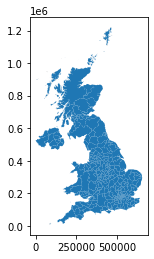

In [12]:
uk_df.plot()

In [13]:
covid_layer.head()

,UtlaCode,UtlaName,LtlaCode,LtlaName,areaCode,areaName,date,newCasesBySpecimenDateRollingSum
0,E08000037,Gateshead,E08000037,Gateshead,E02001682,Ryton,07/07/2021,57
1,E08000037,Gateshead,E08000037,Gateshead,E02001683,Crawcrook & Greenside,07/07/2021,47
2,E08000037,Gateshead,E08000037,Gateshead,E02001684,"Pelaw, Felling Shore & Bill Quay",07/07/2021,67
3,E08000037,Gateshead,E08000037,Gateshead,E02001685,Blaydon South,07/07/2021,85
4,E08000037,Gateshead,E08000037,Gateshead,E02001686,Blaydon North & Winlaton Mill,07/07/2021,77


In [14]:
uk_df.head()

,OBJECTID,LAD21CD,LAD21NM,LAD21NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.835107e+07,66110.011028,"POLYGON ((447213.899 537036.104, 447228.798 53..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.54467,5.455359e+07,41055.789790,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.56752,2.537854e+08,105292.103526,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.55691,2.097308e+08,108085.190140,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.53534,1.974778e+08,107203.152334,"POLYGON ((423496.602 524724.299, 423497.204 52..."
